To do:
* clean up the first part of the notebook using the sutures as an example
* fix the plotting in demonstration of method
* add citations to demonstration of method
* change paths

# LIP analysis

This notebook requires:
* a Python 2 kernel
* installation of pygplates
    * pygplates documentation can be found here: https://www.gplates.org/docs/pygplates/
    * specific for features: http://www.gplates.org/docs/pygplates/generated/pygplates.Feature.html
    * specific for reconstructed feature geometries: https://www.gplates.org/docs/pygplates/generated/pygplates.ReconstructedFeatureGeometry.html#pygplates.ReconstructedFeatureGeometry
* installation of cartopy: `conda install cartopy`

## Modules

In [1]:
import numpy as np
from numpy.core.umath_tests import inner1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import pygplates

import cartopy
import cartopy.crs as ccrs
from shapely.geometry.polygon import Polygon

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

/Users/yuempark/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  


In [2]:
from recon_tools import lat_lon_2_cart
from recon_tools import cart_2_lat_lon
from recon_tools import fast_cross
from recon_tools import cross_and_normalize
from recon_tools import intersection
from recon_tools import check_polygon_in_band
from recon_tools import get_area_in_band
from recon_tools import get_areas_in_bands
from recon_tools import get_length_in_band
from recon_tools import get_lengths_in_bands
from recon_tools import plot_reconstruction
from recon_tools import plot_polygons

## Functions

In [3]:
def get_LIP_areas_in_bands(reconstructed_feature_geometries, lat_mins, lat_maxs,
                           halflife, cover_removal, cover_halflife):
    """
    Get the area of all LIP features in each latitude band, with additional calculations for:
    - scenario (A) features decaying exponentially
    - scenatio (B) covered features disappearing and other features decaying exponentially

    Parameters
    ----------
    reconstructed_feature_geometries : list
        list of reconstructed features output from a pygplates reconstruction
        
    lat_mins : array
        array of latitude minimums of each latitude band
        
    lat_maxs : array
        array of latitude maximums of each latitude band
        
    halflife : array
        half-lives of exponential decay for scenario (A) - if multiple values are provided, multiple scenario (A)s
        will be calculated
        
    cover_removal : list of booleans
        if True, instantly remove, if False, remove 50% instantly for scenario (B) - if multiple values are
        provided, multiple scenario (B)s will be calculated. The length of this list must match the length of
        'cover_halflife'
        
    cover_halflife : array
        half-lives of exponential decay for the uncovered features in scenario (B) - if multiple values are
        provided, multiple scenario (B)s will be calculated. The length of this array must match the length of
        'cover_removal'

    Returns
    -------
    areas : array
        list of total area in each latitude band
        
    area_polygons : list of polygons
        list of all sliced polygons for which areas were calculated
        
    areas_decay : list of arrays
        each array contains the total area in each latitude band under scenario (A) - one array per value
        provided in 'halflife'
        
    areas_cover : list of arrays
        each array contains the total area in each latitude band under scenario (B) - one array per value
        provided in 'cover_removal' and 'cover_halflife'
    """
    # storage vectors
    areas = np.array([])
    area_polygons = []
    areas_decay_temp = []
    areas_cover_temp = []
    
    # convert halflives to decay constants
    lamb = np.log(2)/halflife
    cover_lamb = np.log(2)/cover_halflife

    # iterate over each latitude band
    for i in range(len(lat_mins)):

        # this float stores the total LIP area within the latitude band
        accumulated_area = 0

        # these arrays store the total LIP area within the latitude band under scenarios A and B
        # one element per value provided in 'halflife' for scenario A
        # one element per value provided in 'cover_removal' and 'cover_halflife' for scenario B
        accumulated_area_decay = np.zeros(len(halflife))
        accumulated_area_cover = np.zeros(len(cover_halflife))

        # iterate over each polygon
        for j in range(len(reconstructed_feature_geometries)):

            # get the eruption age, reconstruction age, feature age, feature name, and feature ID
            begin_date, end_date = reconstructed_feature_geometries[j].get_feature().get_valid_time()
            now_date = reconstructed_feature_geometries[j].get_reconstruction_time()
            feature_age = begin_date - now_date
            feature_name = reconstructed_feature_geometries[j].get_feature().get_name()
            feature_Id = reconstructed_feature_geometries[j].get_feature().get_feature_id().get_string()

            # get the actual polygon
            current_polygon = reconstructed_feature_geometries[j].get_reconstructed_geometry()

            # check if the polygon is in the band
            in_band = check_polygon_in_band(current_polygon, lat_mins[i], lat_maxs[i])

            # only perform the calculations if the polygon is within the latitude band
            if in_band:
                
                # do the calculation
                area, band_polygon = get_area_in_band(current_polygon, lat_mins[i], lat_maxs[i])

                # store results
                # for the scenario which does not implement any post-emplacement scenario, only add the area
                # if the LIP erupted after 520 Ma
                if begin_date<=520:
                    accumulated_area = accumulated_area + area
                area_polygons.append(band_polygon)

                # decay method (scenario A)
                for k in range(len(halflife)):
                    
                    # scale the area based on the exponential decay equation
                    decay_area = area * np.exp(-lamb[k]*feature_age)
                    accumulated_area_decay[k] = accumulated_area_decay[k] + decay_area
                        
                # cover method (scenario B)
                # check to see whether we deem the LIP to be covered
                if feature_name in covered_LIP_names:
                    for k in range(len(cover_halflife)):
                        
                        # complete and instant removal
                        if cover_removal[k]:
                            pass
                        
                        # 50% instant removal - the rest decays exponentially 
                        else:
                            decay_area = area/2 * np.exp(-cover_lamb[k]*feature_age)
                            accumulated_area_cover[k] = accumulated_area_cover[k] + decay_area
                            
                # uncovered LIPs
                else:
                    for k in range(len(cover_halflife)):
                        
                        # scale the area based on the exponential decay equation
                        decay_area = area * np.exp(-cover_lamb[k]*feature_age)
                        accumulated_area_cover[k] = accumulated_area_cover[k] + decay_area
                        
        # store total area for the band
        areas = np.append(areas, accumulated_area)
        areas_decay_temp.append(accumulated_area_decay)
        areas_cover_temp.append(accumulated_area_cover)

    # flip our outputs so that each array in our list is for a given input/halflife
    areas_decay = []
    for i in range(len(halflife)):
        this_array = np.array([])
        for j in range(len(areas_decay_temp)):
            this_array = np.append(this_array, areas_decay_temp[j][i])
        areas_decay.append(this_array)
    areas_cover = []
    for i in range(len(cover_halflife)):
        this_array = np.array([])
        for j in range(len(areas_cover_temp)):
            this_array = np.append(this_array, areas_cover_temp[j][i])
        areas_cover.append(this_array)

    # return necessary variables
    return areas, area_polygons, areas_decay, areas_cover

## Read In Files

In [4]:
LIP_feature_collection = pygplates.FeatureCollection.read('./data/LIPs/LIP_Outline_edited.shp')
craton_feature_collection = pygplates.FeatureCollection.read('./paleogeo_models/CEED6+Kazakh/CEED6+D18_Kazakh.shp')
model = './paleogeo_models/TC2017_SHM2017_D2018.rot'

In [5]:
ice = pd.read_csv('./data/ice/IceExtent_Myr.csv')

## Demonstration of Method

To illustrate how the LIP zonal areas are calculated using this code, below is a demonstration of the method for a single time slice at 40 Ma.

First, we set up the latitude bands that we will be summing areas over:

In [6]:
# band_width must be a factor of 90
band_width = 5
lat_mins = np.arange(-90           , 90           , band_width)
lat_maxs = np.arange(-90+band_width, 90+band_width, band_width)
lat_mids = lat_mins + (lat_maxs-lat_mins)/2

Next, we perform the paleogeographic reconstruction for 40 Ma using pygplates:

In [7]:
# input parameters
t = 40      # reconstruction time
anchor = 1  # anchor plate ID

# carry out the reconstruction for the cratons
reconstructed_cratons = []
pygplates.reconstruct(craton_feature_collection, model, reconstructed_cratons, t, anchor)

# carry out the reconstruction for the LIPs
reconstructed_LIPs = []
pygplates.reconstruct(LIP_feature_collection, model, reconstructed_LIPs, t, anchor)

Plot the reconstructed cratons and LIPs:

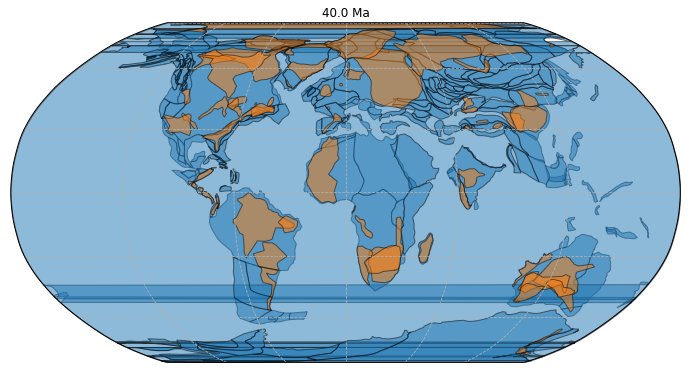

In [8]:
plot_reconstruction([reconstructed_cratons, reconstructed_LIPs], ['C0','C1'], lon_0=0)

Calculate the area of reconstructed cratons and LIPs within each of the latitude bands defined above:

In [9]:
# perform the calculations for cratons
areas_cratons, area_polygons_cratons = get_areas_in_bands(reconstructed_cratons, lat_mins, lat_maxs)

# perform the calculations for LIPs
areas_LIPs, area_polygons_LIPs = get_areas_in_bands(reconstructed_LIPs, lat_mins, lat_maxs)

Plot the calculated zonal areas:

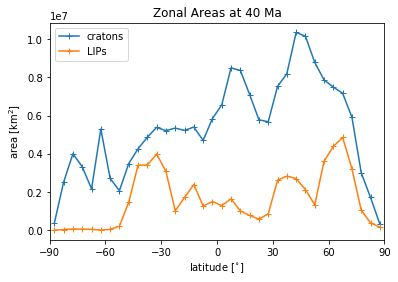

In [10]:
# define column names
cols = ['area_km2','minimum_latitude','maximum_latitude']

# set up dataframes with the calculated zonal areas and their latitude bands
df_cratons = pd.DataFrame({'minimum_latitude':lat_mins, 'maximum_latitude':lat_maxs, 'area_km2':areas_cratons})
df_cratons = df_cratons[cols]

df_LIPs = pd.DataFrame({'minimum_latitude':lat_mins, 'maximum_latitude':lat_maxs, 'area_km2':areas_LIPs})
df_LIPs = df_LIPs[cols]

# plot
fig, ax = plt.subplots()
ax.plot((df_cratons['minimum_latitude']+(df_cratons['maximum_latitude']-df_cratons['minimum_latitude'])/2),
        df_cratons['area_km2'], '+-', c='C0', label='cratons')
ax.plot((df_LIPs['minimum_latitude']+(df_LIPs['maximum_latitude']-df_LIPs['minimum_latitude'])/2),
        df_LIPs['area_km2'], '+-', c='C1', label='LIPs')
ax.set_xlabel('latitude [$^{\circ}$]')
ax.set_ylabel('area [km$^{2}$]')
ax.set_xlim(-90,90)
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.set_title('Zonal Areas at 40 Ma')
ax.legend()
plt.show(fig)

Do a reality check to make sure that our calculated craton areas are reasonable.

Citations:
* 
* 

In [11]:
print('relative to area of exposed land (Coble et al., 1987) : {:.2f}'.format(np.sum(df_cratons['area_km2'])/148.3e6))
print('relative to area of continental crust (Cogley, 1984)  : {:.2f}'.format(np.sum(df_cratons['area_km2'])/2.1e8))

relative to area of exposed land (Coble et al., 1987) : 1.30
relative to area of continental crust (Cogley, 1984)  : 0.92


## Calculations over the Phanerozoic

Here, we apply the method illustrated above for 545 Ma to the present.

### Calculation Set Up

Set up the model:

In [12]:
# create the latitude bands
band_width = 5
lat_mins = np.arange(-90           , 90           , band_width)
lat_maxs = np.arange(-90+band_width, 90+band_width, band_width)
lat_mids = lat_mins + (lat_maxs-lat_mins)/2

# time resolution
t_step = -5

# anchor plate ID
anchor = 1

# set up the time vector
t_start = 545
t_stop = 0
ts = np.arange(t_start, t_stop+t_step, t_step)

# the halflife for exponential decay
halflife = [120]

# the halflife for exponential decay with burial/cover of specified LIPs (see below)
cover_removal = [True]
cover_halflife = [120]

Specify which LIPs are associated with successful rifting and subsidence:

In [13]:
covered_LIP_names = ['Keweenawan',
                     'Wichita',
                     'CAMP',
                     'NW Australia Margin',
                     'Parana-Etendeka',
                     'Seychelles',
                     'North Atlantic',
                     'Afar']

### Perform Calculations

The calculations take some time to perform (~30 minutes) - in order to save some time, the following boolean sets whether the calculations are performed (True), or whether we read in the last set of calculations (False) for the cases in which we just want to visualize/analyze the results:

In [14]:
refresh = False

Now perform the calculations:

In [15]:
# perform the calculations if we set it to above
if refresh:
    
    # get the unique ID, name, eruption age, and area associated with each LIP geometry
    LIP_Ids = []
    LIP_names = []
    LIP_begins = []
    LIP_areas = []
    for feature in LIP_feature_collection:
        LIP_Id = feature.get_feature_id().get_string()
        LIP_Ids.append(LIP_Id)
        LIP_name = feature.get_name()
        LIP_names.append(LIP_name)
        LIP_begin, LIP_end = feature.get_valid_time()
        LIP_begins.append(LIP_begin)
        LIP_area = feature.get_geometry().get_area() * 6371.009**2
        LIP_areas.append(LIP_area)
        
    # store those properties in a dataframe
    LIP_properties = pd.DataFrame({'Ids':LIP_Ids,'names':LIP_names,'begins':LIP_begins,'areas':LIP_areas})
    
    # initialize storage dataframes for the zonal areas
    areas_cratons_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_decay_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_cover_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})

    # iterate through the time vector
    for i in range(len(ts)):

        # carry out the reconstruction for the cratons and LIPs
        reconstructed_cratons = []
        pygplates.reconstruct(craton_feature_collection, model, reconstructed_cratons, ts[i], anchor)
        reconstructed_LIPs = []
        pygplates.reconstruct(LIP_feature_collection, model, reconstructed_LIPs, ts[i], anchor)

        # perform the zonal area calculations for the cratons
        areas_cratons, area_polygons_cratons = get_areas_in_bands(reconstructed_cratons, lat_mins, lat_maxs)
        
        # perform the zonal area calculations for the LIPs using the function defined above
        areas_LIPs,area_polygons_LIPs,areas_LIPs_decay,areas_LIPs_cover =\
            get_LIP_areas_in_bands(reconstructed_LIPs,lat_mins,lat_maxs,
                                   halflife,cover_removal,cover_halflife)

        # store results
        areas_cratons_df['area_km2_' + str(ts[i])] = areas_cratons
        areas_LIPs_df['area_km2_' + str(ts[i])] = areas_LIPs
        areas_LIPs_decay_df['area_km2_' + str(ts[i])] = areas_LIPs_decay[0]
        areas_LIPs_cover_df['area_km2_' + str(ts[i])] = areas_LIPs_cover[0]
        
    # save results to csv's    
    areas_cratons_df.to_csv('code_output/areas_cratons_df.csv', index=False)
    areas_LIPs_df.to_csv('code_output/areas_LIPs_df.csv', index=False)
    areas_LIPs_decay_df.to_csv('code_output/areas_LIPs_decay_df.csv', index=False)
    areas_LIPs_cover_df.to_csv('code_output/areas_LIPs_cover_df.csv', index=False)
    LIP_properties.to_csv('code_output/LIP_properties.csv', index=False)
 
# otherwise, we simply read in the previous set of calculations
else:
    areas_cratons_df = pd.read_csv('code_output/areas_cratons_df.csv')
    areas_LIPs_df = pd.read_csv('code_output/areas_LIPs_df.csv')
    areas_LIPs_decay_df = pd.read_csv('code_output/areas_LIPs_decay_df.csv')
    areas_LIPs_cover_df = pd.read_csv('code_output/areas_LIPs_cover_df.csv')
    LIP_properties = pd.read_csv('code_output/LIP_properties.csv')
    
    # get the new unique ID associated with each LIP geometry
    # this unique ID associated with each LIP changes each time the LIP shapefiles are read by pygplates
    # however, the LIPs are always read in the same order, so we can simply update the IDs as follows
    LIP_Ids = []
    for feature in LIP_feature_collection:
        LIP_Id = feature.get_feature_id().get_string()
        LIP_Ids.append(LIP_Id)
        
    # assign the new feature IDs to the old data
    LIP_properties['Ids'] = LIP_Ids
    
    print('CALCULATIONS NOT PERFORMED: PREVIOUS RESULTS READ IN.')

recon_tools.py:289: RuntimeWarning: invalid value encountered in less
  mask = np.less(new_lats, lat_max+0.1)


Now convert the results to absolute latitude:

In [16]:
# perform the calculations if we set it to above
if refresh:
    
    # initiate new dataframes for absolute latitudes
    num_bands = len(areas_cratons_df.index)

    abs_areas_cratons_df = pd.DataFrame({'lat_maxs':areas_cratons_df['lat_maxs'][(num_bands/2):],
                                         'lat_mids':areas_cratons_df['lat_mids'][(num_bands/2):],
                                         'lat_mins':areas_cratons_df['lat_mins'][(num_bands/2):]})
    abs_areas_cratons_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_df = pd.DataFrame({'lat_maxs':areas_LIPs_df['lat_maxs'][(num_bands/2):],
                                      'lat_mids':areas_LIPs_df['lat_mids'][(num_bands/2):],
                                      'lat_mins':areas_LIPs_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_decay_df = pd.DataFrame({'lat_maxs':areas_LIPs_decay_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_decay_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_decay_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_decay_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_cover_df = pd.DataFrame({'lat_maxs':areas_LIPs_cover_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_cover_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_cover_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_cover_df.reset_index(drop=True, inplace=True)

    # iterate over the time steps
    for i in range(len(ts)):
        
        # iterate over the latitude bands, summing and storing
        for j in range(num_bands/2):
            abs_area = areas_cratons_df['area_km2_'+str(ts[i])][j]+\
                       areas_cratons_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_cratons_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_decay_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_decay_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_decay_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_cover_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_cover_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_cover_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area
            
    # save results to csv's    
    abs_areas_cratons_df.to_csv('code_output/abs_areas_cratons_df.csv', index=False)
    abs_areas_LIPs_df.to_csv('code_output/abs_areas_LIPs_df.csv', index=False)
    abs_areas_LIPs_decay_df.to_csv('code_output/abs_areas_LIPs_decay_df.csv', index=False)
    abs_areas_LIPs_cover_df.to_csv('code_output/abs_areas_LIPs_cover_df.csv', index=False)
    
# otherwise, we simply read in the previous set of calculations
else:
    abs_areas_cratons_df = pd.read_csv('code_output/abs_areas_cratons_df.csv')
    abs_areas_LIPs_df = pd.read_csv('code_output/abs_areas_LIPs_df.csv')
    abs_areas_LIPs_decay_df = pd.read_csv('code_output/abs_areas_LIPs_decay_df.csv')
    abs_areas_LIPs_cover_df = pd.read_csv('code_output/abs_areas_LIPs_cover_df.csv')
    
    print('CALCULATIONS NOT PERFORMED: PREVIOUS RESULTS READ IN.')

## Visualization and Analysis of Results

Show how the total area of LIPs changes through time for each of the models:

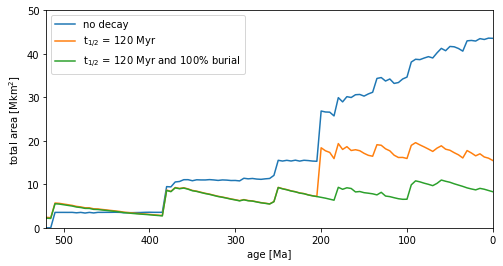

In [35]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(ts, np.sum(abs_areas_LIPs_df.values[:,3:]/1e6, axis=0),
        c='C0', label='no decay')
ax.plot(ts, np.sum(abs_areas_LIPs_decay_df.values[:,3:]/1e6, axis=0),
        c='C1', label='t$_{1/2}$ = 120 Myr')
ax.plot(ts, np.sum(abs_areas_LIPs_cover_df.values[:,3:]/1e6, axis=0),
        c='C2', label='t$_{1/2}$ = 120 Myr and 100% burial')

ax.legend()
ax.set_xlim(520,0)
ax.set_ylim(0,50)
ax.set_xlabel('age [Ma]')
ax.set_ylabel('total area [Mkm$^{2}$]')
plt.show(fig)

Show how the area of LIPs within 15$^{/circ}$ of the equator changes through time for each of the models:

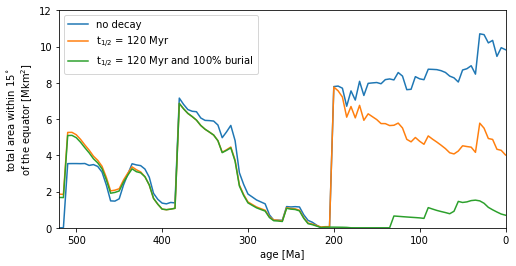

In [32]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(ts, np.sum(abs_areas_LIPs_df.values[:3,3:]/1e6, axis=0),
        c='C0', label='no decay')
ax.plot(ts, np.sum(abs_areas_LIPs_decay_df.values[:3,3:]/1e6, axis=0),
        c='C1', label='t$_{1/2}$ = 120 Myr')
ax.plot(ts, np.sum(abs_areas_LIPs_cover_df.values[:3,3:]/1e6, axis=0),
        c='C2', label='t$_{1/2}$ = 120 Myr and 100% burial')

ax.legend()
ax.set_xlim(520,0)
ax.set_ylim(0,12)
ax.set_xlabel('age [Ma]')
ax.set_ylabel('total area within 15$^{\circ}$\nof the equator [Mkm$^{2}$]')
plt.show(fig)

Here we make a plot of the LIP shapefiles being used - note that this code takes a minute or two to run:

In [36]:
# get names of shapefiles
plot_original_A = './data/LIPs/LIP_Outline_edited_plot_0_520.shp'
plot_CEED6 = './paleogeo_models/CEED6+Kazakh/CEED6+D18_Kazakh.shp'

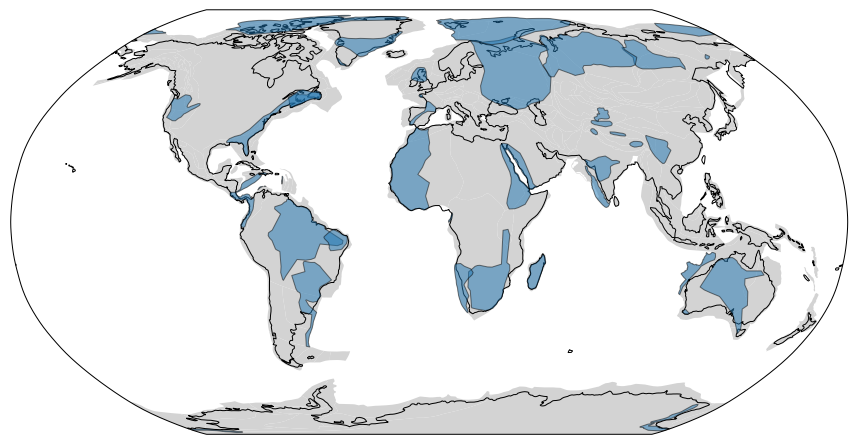

In [39]:
# set up figure and axis
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.Robinson())

# plot CEED6
shape_feature = ShapelyFeature(Reader(plot_CEED6).geometries(),
                               ccrs.PlateCarree(), edgecolor='none', facecolor='lightgrey')
ax.add_feature(shape_feature)

# coastlines
ax.coastlines(color='black')

# plot original polygons
shape_feature = ShapelyFeature(Reader(plot_original_A).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='C0', alpha=0.5)
ax.add_feature(shape_feature)

plt.show()

## Table of Data

Output a data table that combines the important variables into a single dataframe:

In [42]:
# set up the columns
output_df = pd.DataFrame(columns=['age (Ma)',
                                  'natural decay total',
                                  'natural decay within 15',
                                  'natural decay outside 15',
                                  'burial total',
                                  'burial within 15',
                                  'burial outside 15'])

output_df['age (Ma)'] = ts


output_df['natural decay total'] = np.sum(abs_areas_LIPs_decay_df.values[:,3:], axis=0)
output_df['natural decay within 15'] = np.sum(abs_areas_LIPs_decay_df.values[:3,3:], axis=0)
output_df['natural decay outside 15'] = np.sum(abs_areas_LIPs_decay_df.values[3:,3:], axis=0)

output_df['burial total'] = np.sum(abs_areas_LIPs_cover_df.values[:,3:], axis=0)
output_df['burial within 15'] = np.sum(abs_areas_LIPs_cover_df.values[:3,3:], axis=0)
output_df['burial outside 15'] = np.sum(abs_areas_LIPs_cover_df.values[3:,3:], axis=0)

output_df = output_df[output_df['age (Ma)']<=520]
output_df.reset_index(drop=True, inplace=True)

output_df.to_csv('code_output/tropical_LIP_areas.csv', index=False)
output_df.to_csv('code_output/tropical_LIP_areas.txt', index=False, header=False)